# Unit 5 - Financial Planning

In [251]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import datetime, timedelta, date
import hvplot.pandas
from bokeh.models.formatters import NumeralTickFormatter

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv("the.env")

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
#For the prototype, we’ll assume that the member holds the 1.2 Bitcoins (BTC) and 5.3 Ethereum coins (ETH).
# Set current amount of crypto assets
my_btc =1.2
my_eth = 5.3

In [4]:
# Crypto API URLs (API Documentation: https://alternative.me/crypto/api/)
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [132]:
# Fetch current BTC price
BTC_data = requests.get(btc_url).json()
#print(json.dumps(BTC_data, indent=4))
BTC_price = BTC_data['data']['1']['quotes']['CAD']['price']
BTC_price

37648.1105

In [133]:
# Fetch current ETH price
ETH_data = requests.get(eth_url).json()
#print(json.dumps(ETH_data, indent = 4))
ETH_price = ETH_data['data']['1027']['quotes']['CAD']['price']
ETH_price

2399.722325

In [134]:
# Compute current value of my crpto
# YOUR CODE HERE!
my_btc_value = my_btc * BTC_price
my_eth_value = my_eth * ETH_price
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $45177.73
The current value of your 5.3 ETH is $12718.53


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [8]:
# Set current amount of shares
#For the prototype, assume that the member holds 50 shares of SPY, which represents the stock portion of their portfolio, 
                                                # and 200 shares of AGG, which represents the bond portion.
my_agg = 200
my_spy = 50

In [9]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [166]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
# Get current closing prices function
def get_price(tickers, timeframe, start_date, end_date):
    df_tickers = alpaca.get_bars(
        tickers,
        timeframe,
        start = start_date,
        end = end_date
    ).df
    return df_tickers

In [167]:
# Format current date as ISO format
#today = pd.Timestamp(date.today(), tz="America/New_York").isoformat()
thedate = date.today()
date_ISO = pd.Timestamp(thedate, tz="America/New_York").isoformat()
date_ISO

'2023-03-24T00:00:00-04:00'

In [161]:
# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"


In [169]:

df_tickers = get_price(tickers, timeframe, date_ISO, date_ISO)
# if the user check data when the market is not open (e.g. weekend, midnight etc.)
# then we check one day before untile we get the data
while df_tickers.shape == (0,0):
    thedate = thedate - timedelta(1)
    date_ISO = pd.Timestamp(thedate, tz="America/New_York").isoformat() 
    df_tickers = get_price(tickers, timeframe, date_ISO, date_ISO)
print(f'The last_updated_datetime is: {thedate}')      

The last_updated_datetime is: 2023-03-24


In [170]:
df_tickers

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2023-03-24 04:00:00+00:00,100.280,100.49,99.95,100.16,6204077,23906,100.145650,AGG
2023-03-24 04:00:00+00:00,391.841,395.84,389.40,395.75,107180049,802488,393.109256,SPY


In [171]:
AGG_price = df_tickers[df_tickers.symbol == 'AGG'].close.values
my_agg_value = float(AGG_price * my_agg)
print(f"The current value of your {my_agg} AGG is ${my_agg_value:0.2f}")

The current value of your 200 AGG is $20032.00


In [172]:
SPY_price = df_tickers[df_tickers.symbol == 'SPY'].close.values
my_spy_value = float(SPY_price * my_spy)
print(f"The current value of your {my_spy} SPY is ${my_spy_value:0.2f}")

The current value of your 50 SPY is $19787.50


### Savings Health Analysis

In [173]:
# Set monthly household income
monthly_income = 12000

df_savings = pd.DataFrame(columns = ['amount','currency'], index = ['crypto','shares'])
df_savings['currency'] = ['CAD','USD']
df_savings.loc['shares','amount'] = round(my_agg_value + my_spy_value,2)
df_savings.loc['crypto','amount'] = round(BTC_price + ETH_price,2)
df_savings

,amount,currency
crypto,40047.83,CAD
shares,39819.5,USD


## Using ExchangeRate API to make a currency converter
references: 
https://www.thepythoncode.com/article/make-a-currency-converter-in-python#erapi

https://www.exchangerate-api.com/

In [174]:
from dateutil.parser import parse 

def get_all_exchange_rates_erapi(src):
    url = f"https://open.er-api.com/v6/latest/{src}"
    # request the open ExchangeRate API and convert to Python dict using .json()
    data = requests.get(url).json()
    if data["result"] == "success":
        # request successful
        # get the last updated datetime
        last_updated_datetime = parse(data["time_last_update_utc"])
        # get the exchange rates
        exchange_rates = data["rates"]
    return last_updated_datetime, exchange_rates

def convert_currency_erapi(src, dst, amount):
    # get all the exchange rates
    last_updated_datetime, exchange_rates = get_all_exchange_rates_erapi(src)
    # convert by simply getting the target currency exchange rate and multiply by the amount
    return last_updated_datetime, exchange_rates[dst] * amount



In [175]:
source_currency = 'USD'
destination_currency = 'CAD'
amount = my_agg_value + my_spy_value
last_updated_datetime, after_exchange = convert_currency_erapi(source_currency, destination_currency, amount)
print("Last updated datetime:", last_updated_datetime)
print(f"{amount} {source_currency} = {after_exchange} {destination_currency}")

Last updated datetime: 2023-03-25 00:02:32+00:00
39819.5 USD = 54745.361741 CAD


In [176]:
df_savings.loc['shares','amount'] = round(after_exchange,2)
df_savings.loc['shares','currency'] = destination_currency
df_savings

,amount,currency
crypto,40047.83,CAD
shares,54745.36,CAD


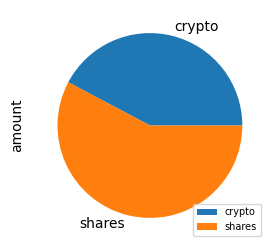

In [177]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', figsize = (3,3)).legend(fontsize=7, loc="lower right")


In [178]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_saving = df_savings.amount.sum()

# Validate saving health
if total_saving > emergency_fund:
    print("Congratulations! You have enough money in this fund.")
elif total_saving == emergency_fund:
    print("Congratulations! You are reaching the financial goal.")
else:
    print(f'You are {emergency_fund - total_saving} CAD away from reaching the goal.')

Congratulations! You have enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [183]:
# Set start and end dates of five years back from today.
end_date = pd.Timestamp(date.today(), tz='America/New_York').isoformat()
start_date = pd.Timestamp(date.today() - timedelta(5*365), tz='America/New_York').isoformat()
print(f' start date: {start_date}\n end date: {end_date}')

 start date: 2018-03-25T00:00:00-04:00
 end date: 2023-03-24T00:00:00-04:00


In [188]:
# Get 5 years' worth of historical data for SPY and AGG

# Set timeframe to "1Day"
timeframe = "1Day"
tickers = ["AGG", "SPY"]
# Set start and end datetimes between now and 5 years ago.
df_stock_data = get_price(tickers, timeframe, start_date, end_date)


In [189]:
# Reorganize the DataFrame
# Separate ticker data
df_AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
df_SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([df_AGG,df_SPY], axis=1, keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  106.64  106.71  106.47  106.57  4546535   
2018-03-27 04:00:00+00:00  106.63  106.95  106.61  106.88  4566884   
2018-03-28 04:00:00+00:00  107.05  107.10  106.88  106.94  5617206   
2018-03-29 04:00:00+00:00  106.95  107.26  106.95  107.25  9199453   
2018-04-02 04:00:00+00:00  106.90  107.04  106.82  106.90  7280259   

                                                      SPY                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2018-03-26 04:00:00+00:00       19722  106.583861  262.13  265.43  259.4100   
2018-03-27 04:00:00+00:00       14293  106.826049  266.17  266.77  258.8400   
2018-03-28 04:00:00+00:00       18689  106.978133  260.75  262.64  258.5800   
2018-03-29 04:00:00+00:00       20364  107.212902  261.12  265.26  259.8389   
2018-04-02 04:00:00+00:00       24906  106.927635  262.55  263.13  254.6700   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2018-03-26 04:00:00+00:00  265.14  143141239      450168  262.353110  
2018-03-27 04:00:00+00:00  260.76  130806695      538201  263.145788  
2018-03-28 04:00:00+00:00  259.85  146510333      590467  260.395684  
2018-03-29 04:00:00+00:00  263.43  125470572      436558  262.835186  
2018-04-02 04:00:00+00:00  257.52  186324337      643544  258.212001

In [220]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [221]:
# Printing the simulation input data
MC_30year.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  106.64  106.71  106.47  106.57  4546535   
2018-03-27 04:00:00+00:00  106.63  106.95  106.61  106.88  4566884   
2018-03-28 04:00:00+00:00  107.05  107.10  106.88  106.94  5617206   
2018-03-29 04:00:00+00:00  106.95  107.26  106.95  107.25  9199453   
2018-04-02 04:00:00+00:00  106.90  107.04  106.82  106.90  7280259   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-03-26 04:00:00+00:00       19722  106.583861          NaN  262.13   
2018-03-27 04:00:00+00:00       14293  106.826049     0.002909  266.17   
2018-03-28 04:00:00+00:00       18689  106.978133     0.000561  260.75   
2018-03-29 04:00:00+00:00       20364  107.212902     0.002899  261.12   
2018-04-02 04:00:00+00:00       24906  106.927635    -0.003263  262.55   

                                                                            \
                             high       low   close     volume trade_count   
timestamp                                                                    
2018-03-26 04:00:00+00:00  265.43  259.4100  265.14  143141239      450168   
2018-03-27 04:00:00+00:00  266.77  258.8400  260.76  130806695      538201   
2018-03-28 04:00:00+00:00  262.64  258.5800  259.85  146510333      590467   
2018-03-29 04:00:00+00:00  265.26  259.8389  263.43  125470572      436558   
2018-04-02 04:00:00+00:00  263.13  254.6700  257.52  186324337      643544   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-03-26 04:00:00+00:00  262.353110          NaN  
2018-03-27 04:00:00+00:00  263.145788    -0.016520  
2018-03-28 04:00:00+00:00  260.395684    -0.003490  
2018-03-29 04:00:00+00:00  262.835186     0.013777  
2018-04-02 04:00:00+00:00  258.212001    -0.022435

In [222]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/wanlin/Documents/GitHub/financial-planner-API/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998495,0.993754,1.009649,1.007995,1.004184,1.010292,1.009663,1.003194,0.991582,1.007867,...,0.997132,1.009806,1.015055,0.995844,0.992404,0.982001,1.007761,0.995696,0.998110,1.005187
2,0.995657,0.990121,0.994927,1.010584,1.011912,1.011549,1.018638,1.000109,1.002825,0.990933,...,0.989141,1.011690,1.013036,1.005430,0.982741,0.991781,1.012118,0.994916,0.989874,1.001577
3,0.995349,0.996119,0.985854,1.006664,1.016945,1.014961,1.020710,0.993624,1.000118,0.993800,...,0.986718,1.008191,1.011081,1.004022,1.000883,0.990475,1.020997,0.999663,0.996470,0.999943
4,0.994913,0.992170,0.987958,1.012117,0.991966,1.024506,1.034124,1.008834,1.008685,0.987325,...,0.976127,0.999008,1.008443,0.996890,0.996580,0.997271,1.014664,0.994177,1.013616,0.984145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1.490583,4.720418,16.334357,7.806940,5.585172,3.421191,5.108748,7.043335,10.083926,2.633671,...,6.724915,6.832249,4.005839,2.593360,2.450404,8.356999,8.914926,3.747838,4.495837,3.268155
7557,1.491850,4.685554,16.326186,7.883102,5.613990,3.448260,5.089844,7.082211,10.189522,2.650660,...,6.774214,6.794604,4.052439,2.587545,2.427843,8.402757,8.934339,3.766056,4.510532,3.198610
7558,1.481663,4.633666,16.378743,7.861260,5.613626,3.460197,5.073735,7.038257,10.292322,2.620254,...,6.777316,6.767974,4.069377,2.599274,2.446834,8.490890,9.001483,3.718611,4.515760,3.235138
7559,1.489021,4.606643,16.344720,7.775780,5.635948,3.448248,5.048940,7.065172,10.226478,2.638434,...,6.834601,6.704727,4.065630,2.574935,2.455000,8.538242,8.936679,3.727683,4.600203,3.179371


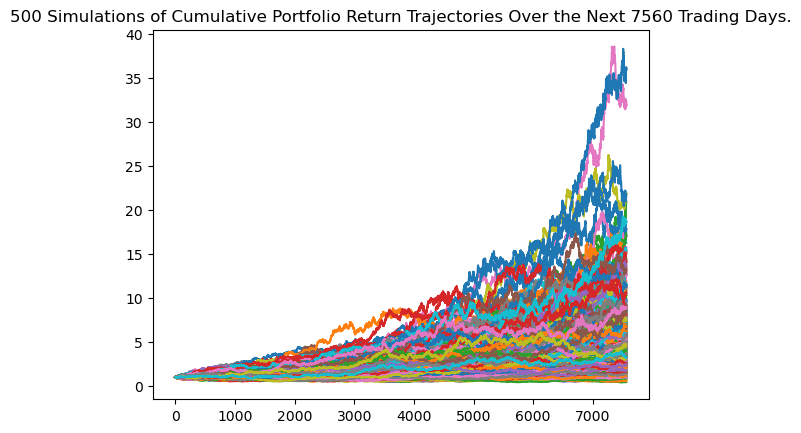

In [223]:
# Plot simulation outcomes
line_plot = MC_30year.plot_simulation()

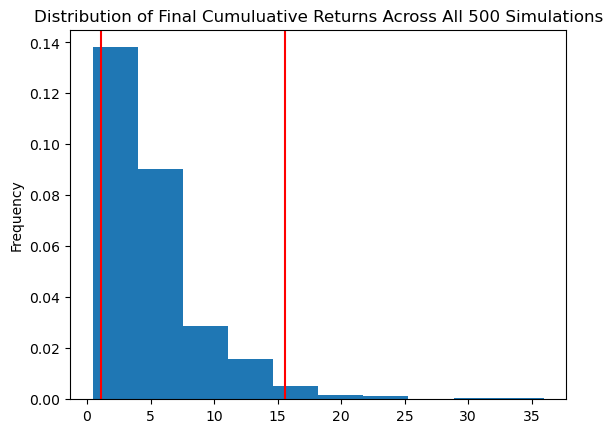

In [224]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30year.plot_distribution()

### Retirement Analysis

In [231]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_30year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              5.270294
std               4.083920
min               0.458753
25%               2.650215
50%               4.121305
75%               6.532100
max              35.949198
95% CI Lower      1.114391
95% CI Upper     15.591959
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [232]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
# YOUR CODE HERE!
ci_lower_30 = round(tbl['95% CI Lower']*initial_investment,2)
ci_upper_30 = round(tbl['95% CI Upper']*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_30} and ${ci_upper_30}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $22287.81 and $311839.18


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [233]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_30_1 = round(tbl['95% CI Lower']*initial_investment,2)
ci_upper_30_1 = round(tbl['95% CI Upper']*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_30_1} and ${ci_upper_30_1}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $33431.72 and $467758.77


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [207]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.20,.80],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [208]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/wanlin/Documents/GitHub/financial-planner-API/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.973265,1.007062,0.993417,0.995302,0.986754,1.009071,0.986904,1.015590,1.002603,1.002294,...,0.989616,0.997333,1.013749,1.005779,0.992575,0.994336,1.005163,1.001449,0.991530,0.995519
2,0.967286,1.010844,0.999122,1.001383,0.988570,1.018181,0.979418,1.012260,0.998191,1.003497,...,0.977612,1.001243,1.003339,1.003370,0.998034,0.971424,0.991289,1.018238,0.991016,1.009467
3,0.972878,1.007111,1.007676,0.989396,0.987457,1.015488,0.991794,1.006795,1.013880,0.994513,...,0.966646,1.007643,1.007480,1.012988,1.003043,0.995614,0.994231,1.019933,1.010702,1.021447
4,0.972359,0.991979,0.998101,0.981848,0.973678,1.010091,0.986273,1.004884,1.030520,1.020837,...,0.951676,1.028621,1.004502,1.015169,0.993553,1.023505,0.990851,1.027384,1.016392,1.014884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.145824,1.534990,1.973130,0.516739,0.938972,1.267555,1.248714,1.272482,1.383513,1.775672,...,2.173960,1.535078,1.071101,1.340260,1.176101,1.881207,1.315265,1.798417,1.308576,1.038647
1257,2.125717,1.522433,1.950610,0.509468,0.937297,1.278824,1.251809,1.284683,1.368596,1.806201,...,2.151348,1.534297,1.072661,1.338989,1.172683,1.919729,1.326141,1.762947,1.305654,1.038429
1258,2.153344,1.531892,1.941944,0.506351,0.942471,1.256089,1.238666,1.292962,1.384413,1.795236,...,2.179897,1.536216,1.068383,1.356932,1.166147,1.913011,1.339260,1.765932,1.331913,1.026156
1259,2.135839,1.523517,1.945950,0.509338,0.954009,1.262399,1.239178,1.307575,1.384715,1.800313,...,2.191393,1.531437,1.070132,1.361956,1.166544,1.922105,1.316098,1.781667,1.319803,1.038961


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

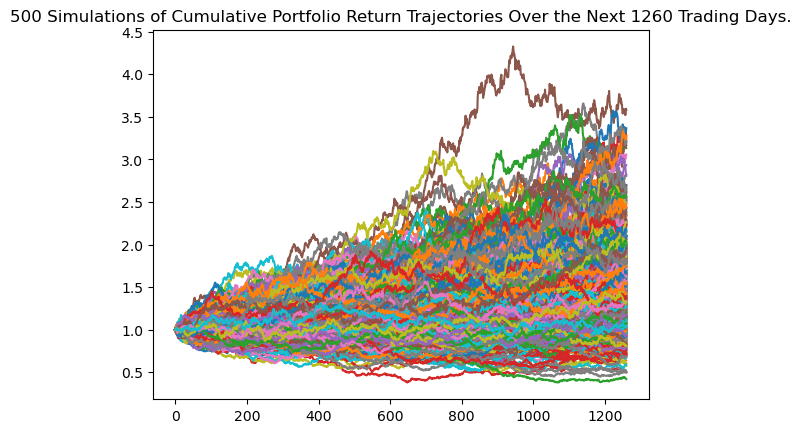

In [209]:
# Plot simulation outcomes
MC_5year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

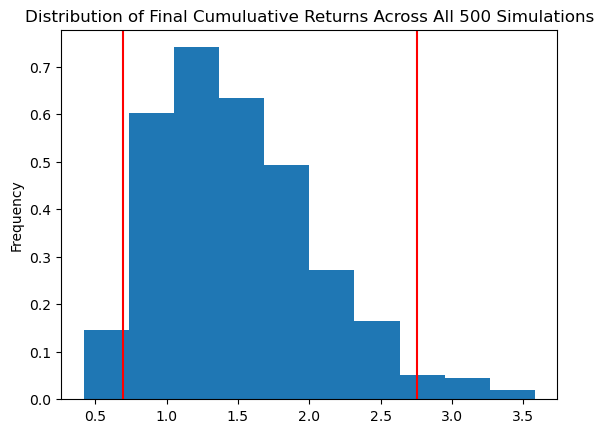

In [210]:
# Plot probability distribution and confidence intervals
MC_5year.plot_distribution()

In [211]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_5year.summarize_cumulative_return()

# Print summary statistics
tbl

count           500.000000
mean              1.500842
std               0.562620
min               0.420756
25%               1.074935
50%               1.424373
75%               1.843163
max               3.579949
95% CI Lower      0.691560
95% CI Upper      2.754840
Name: 1260, dtype: float64

In [213]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl[8]*initial_investment,2)
ci_upper_five = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $13831.2 and $55096.79


### Ten Years Retirement Option

In [214]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.20,.80],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [215]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/wanlin/Documents/GitHub/financial-planner-API/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002959,1.002880,0.982150,1.006034,0.991490,0.987889,0.984834,1.013136,0.996967,0.996246,...,0.998489,0.993262,0.990391,1.007447,0.998099,0.996290,1.001395,1.015855,0.979533,0.996291
2,0.994968,0.995332,1.000757,1.004628,1.017882,0.993614,0.977125,1.015067,1.008503,1.000596,...,0.990699,0.986547,1.002429,0.998056,0.993969,0.992387,0.991164,1.027659,0.972672,0.991082
3,0.988646,0.996499,0.999823,1.014670,1.018737,1.002523,0.965522,1.020043,1.010870,0.994236,...,0.979021,0.982552,1.011587,0.991332,1.000378,0.974455,0.992535,1.026134,0.947003,1.005509
4,0.981327,1.000674,1.001393,1.024674,1.012191,1.006686,0.954877,1.009778,1.013604,0.986993,...,0.982523,0.980992,1.001801,1.011454,1.001276,0.975960,0.997932,1.016140,0.958459,1.006802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.685987,2.306728,2.239205,2.366189,3.948095,0.649211,1.745286,0.527832,0.568264,3.796858,...,2.958323,2.214407,0.981783,1.345608,3.013874,1.619031,2.198623,1.953719,2.034789,2.553724
2517,1.697451,2.298286,2.253365,2.343905,3.962438,0.658332,1.748953,0.530935,0.569081,3.743461,...,2.990667,2.245425,0.977699,1.341854,3.062605,1.614836,2.198211,1.977092,2.031265,2.531711
2518,1.694584,2.300470,2.302934,2.370131,3.971711,0.673071,1.740715,0.528584,0.564177,3.767363,...,3.001192,2.263433,0.972414,1.356560,3.076990,1.601359,2.222992,2.001019,2.076244,2.508544
2519,1.702892,2.281453,2.308612,2.406372,3.946264,0.665129,1.755761,0.531055,0.566599,3.819161,...,2.963858,2.260936,0.973916,1.367424,3.078126,1.608949,2.224088,1.991626,2.087533,2.537878


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

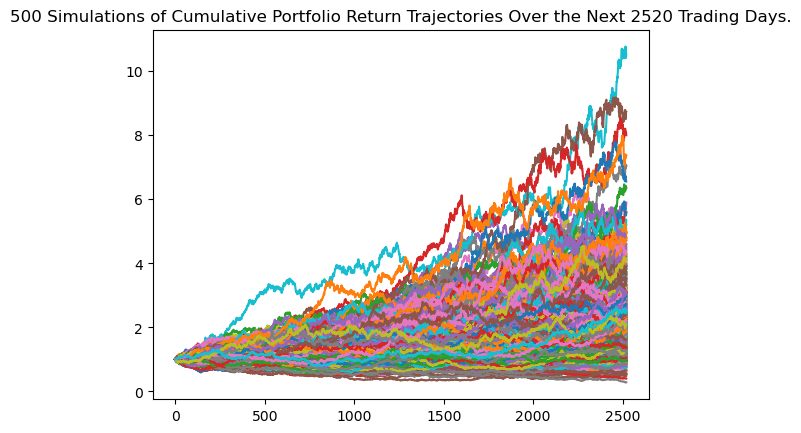

In [216]:
# Plot simulation outcomes
MC_10year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

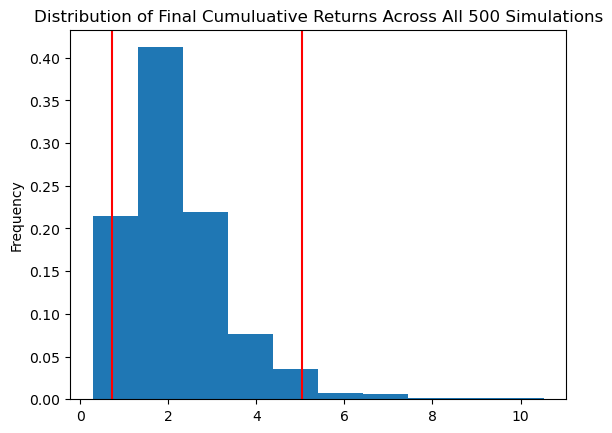

In [217]:
# Plot probability distribution and confidence intervals
MC_10year.plot_distribution()

In [218]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_10year.summarize_cumulative_return()

# Print summary statistics
tbl

count           500.000000
mean              2.220918
std               1.233000
min               0.288549
25%               1.366315
50%               1.991302
75%               2.721423
max              10.527329
95% CI Lower      0.735218
95% CI Upper      5.036585
Name: 2520, dtype: float64

In [219]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl[8]*initial_investment,2)
ci_upper_ten = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $14704.36 and $100731.7


In [235]:
df_forecast = pd.DataFrame(columns = ['initial_investment','CI_lower','CI_upper'], index = ['5years','10years','30years','30years'])
df_forecast['initial_investment'] = [20000,20000,20000,20000*1.5]
df_forecast['CI_lower'] = [ci_lower_five,ci_lower_ten,ci_lower_30,ci_lower_30_1]
df_forecast['CI_upper'] = [ci_upper_five,ci_upper_ten,ci_upper_30,ci_upper_30_1]
df_forecast

,initial_investment,CI_lower,CI_upper
5years,20000.0,13831.20,55096.79
10years,20000.0,14704.36,100731.70
30years,20000.0,22287.81,311839.18
30years,30000.0,33431.72,467758.77
